In [15]:
import csv, os
import matplotlib.pyplot as plt
import numpy as np

def read_csv(dir, run):
    filename = os.path.join(dir, run, "logs.csv")
    steps, eps_ret, eps_n = [], [], []

    with open(filename, 'r') as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        for row in csvreader:            
            if len(row) > 0 and int(row[-1]) > 100:
                steps.append(int(row[2]))
                eps_ret.append(float(row[-2]))
                #eps_n.append(row[-1])
    return steps, eps_ret

def simplify(steps, eps_ret, gap=100000):
    ind = 0
    new_steps, new_eps_ret = [], []
    for n, (i, j) in enumerate(zip(steps, eps_ret)):
        if i > ind:
            new_steps.append(i)
            new_eps_ret.append(j)
            ind += gap
    return new_steps, new_eps_ret
    
def mv(a, n=1000) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n    

In [22]:
#!rm -r logs/planner_logs/lstm_3_1_rec_n_5_rei
#!cp -r logs/torchbeast/torchbeast-20221030-015436 logs/planner_logs
#!mv logs/planner_logs/torchbeast-20221030-015436 logs/planner_logs/lstm_3_1_rec_n_5_rei

!rm -r logs/planner_logs/lstm_3_1_rec_n_10_gbste
!scp -r cam:~/RS/thinker/logs/torchbeast/torchbeast-20221028-011439 logs/planner_logs/lstm_3_1_rec_n_10_gbste
    
!rm -r logs/planner_logs/lstm_3_1_rec_n_5_gbste_large
!scp -r v1:~/RS/thinker/logs/torchbeast/torchbeast-20221029-162947 logs/planner_logs/lstm_3_1_rec_n_5_gbste_large 
    
!rm -r logs/planner_logs/lstm_3_1_rec_n_5_gbste_lstm_attn   
!scp -r v2:~/RS/thinker/logs/torchbeast/torchbeast-20221029-164525 logs/planner_logs/lstm_3_1_rec_n_5_gbste_lstm_attn     
    
!rm -r logs/planner_logs/lstm_3_1_rec_n_5_ste
!scp -r v3:~/RS/thinker/logs/torchbeast/torchbeast-20221030-090748 logs/planner_logs/lstm_3_1_rec_n_5_ste         

out.log                                       100%  342     3.4KB/s   00:00    
logs.csv                                      100%   21MB  15.1MB/s   00:01    
meta.json                                     100% 4786   204.0KB/s   00:00    
fields.csv                                    100%    0     0.0KB/s   00:00    
model.tar                                     100%   12MB  15.8MB/s   00:00    
Welcome to vast.ai. If authentication fails, try again after a few seconds, and double check your ssh key.
Have fun!
meta.json                                     100% 3997    14.0KB/s   00:00    
out.log                                       100%  342     1.7KB/s   00:00    
fields.csv                                    100%    0     0.0KB/s   00:00    
logs.csv                                      100%   13MB   4.8MB/s   00:02    
model.tar                                     100%   56MB   6.4MB/s   00:08    
Welcome to vast.ai. If authentication fails, try again after a few seconds, and dou

<Figure size 640x480 with 0 Axes>

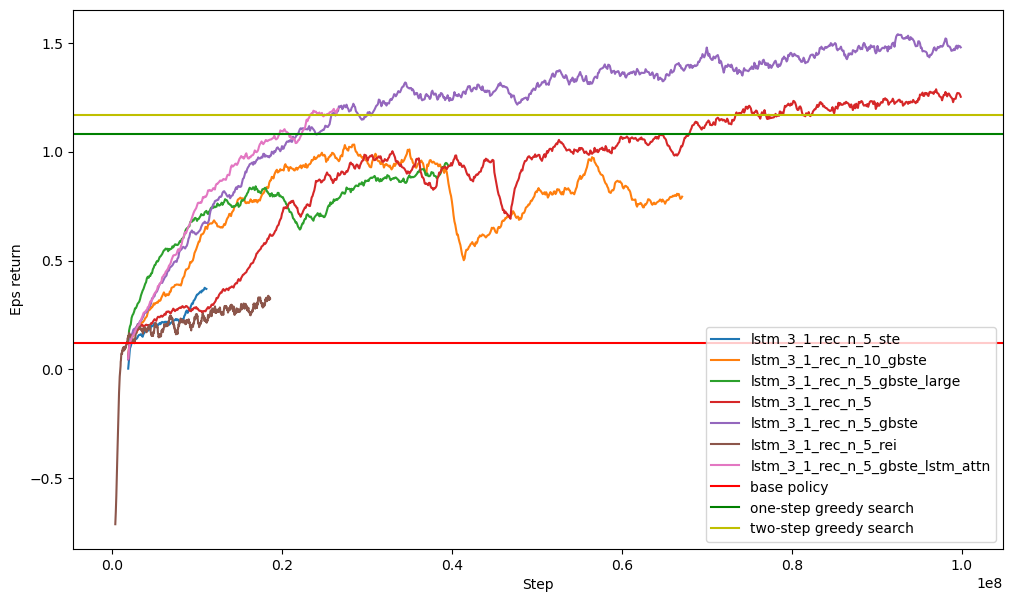

In [23]:
runs = os.listdir('logs/planner_logs')
steps, eps_rets = {}, {}
mv_avg = 20

for run in runs:
    if "." in run or "past" == run: continue
    step, eps_ret = simplify(*read_csv('logs/planner_logs', run))
    steps[run] = step
    eps_rets[run] = eps_ret

plt.figure()
f, ax = plt.subplots(1, 1, figsize=(12,7))

linestyles=["solid", "dashed", "dotted","dashdot"]
for n, run in enumerate(eps_rets.keys()):
    if run == "lstm_3_1_rec_n_5_rei":
        d = 5
    else:
        d = 1        
    ax.plot(np.array(steps[run][mv_avg-1:])/d, 
            mv(eps_rets[run], n=mv_avg), 
            label=run, 
            linestyle=linestyles[n//12])
plt.xlabel('Step')
plt.ylabel('Eps return')
plt.axhline(y=0.12, color='r', label="base policy")
plt.axhline(y=1.08, color='g', label="one-step greedy search")
plt.axhline(y=1.17, color='y', label="two-step greedy search")

plt.legend()
plt.show()    